In [0]:
#Reference:https://www.pyimagesearch.com/
#This file  detects blinks, their parameters and analyzes them[the final main code]
# import the necessary packages
from __future__ import print_function

from scipy.spatial import distance as dist
import scipy.ndimage.filters as signal

from imutils import face_utils

import datetime
import imutils
import dlib

import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import*
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.ndimage.interpolation import shift
import pickle
from queue import Queue

# import the necessary packages

import numpy as np
import cv2

In [0]:
# this "adjust_gamma" function directly taken from : https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

#


#

def blink_detector(output_textfile,input_video):



    Q = Queue(maxsize=7)

    FRAME_MARGIN_BTW_2BLINKS=3
    MIN_AMPLITUDE=0.04
    MOUTH_AR_THRESH=0.35
    MOUTH_AR_THRESH_ALERT=0.30
    MOUTH_AR_CONSEC_FRAMES=20

    EPSILON=0.01  # for discrete derivative (avoiding zero derivative)
    class Blink():
        def __init__(self):

            self.start=0 #frame
            self.startEAR=1
            self.peak=0  #frame
            self.peakEAR = 1
            self.end=0   #frame
            self.endEAR=0
            self.amplitude=(self.startEAR+self.endEAR-2*self.peakEAR)/2
            self.duration = self.end-self.start+1
            self.EAR_of_FOI=0 #FrameOfInterest
            self.values=[]
            self.velocity=0  #Eye-closing velocity



    def eye_aspect_ratio(eye):
        # compute the euclidean distances between the two sets of
        # vertical eye landmarks (x, y)-coordinates
        A = dist.euclidean(eye[1], eye[5])
        B = dist.euclidean(eye[2], eye[4])

        # compute the euclidean distance between the horizontal
        # eye landmark (x, y)-coordinates
        C = dist.euclidean(eye[0], eye[3])

        if C<0.1:           #practical finetuning due to possible numerical issue as a result of optical flow
            ear=0.3
        else:
            # compute the eye aspect ratio
            ear = (A + B) / (2.0 * C)
        if ear>0.45:        #practical finetuning due to possible numerical issue as a result of optical flow
            ear=0.45
        # return the eye aspect ratio
        return ear

    def mouth_aspect_ratio(mouth):

        A = dist.euclidean(mouth[14], mouth[18])

        C = dist.euclidean(mouth[12], mouth[16])

        if C<0.1:           #practical finetuning
            mar=0.2
        else:
            # compute the mouth aspect ratio
            mar = (A ) / (C)

        # return the mouth aspect ratio
        return mar


    def EMERGENCY(ear, COUNTER):
        if ear < 0.21:
            COUNTER += 1

            if COUNTER >= 50:
                print('EMERGENCY SITUATION (EYES TOO LONG CLOSED)')
                print(COUNTER)
                COUNTER = 0
        else:
            COUNTER=0
        return COUNTER

    def Linear_Interpolate(start,end,N):
        m=(end-start)/(N+1)
        x=np.linspace(1,N,N)
        y=m*(x-0)+start
        return list(y)

    def Ultimate_Blink_Check():
        #Given the input "values", retrieve blinks and their quantities
        retrieved_blinks=[]
        MISSED_BLINKS=False
        values=np.asarray(Last_Blink.values)
        THRESHOLD=0.4*np.min(values)+0.6*np.max(values)   # this is to split extrema in highs and lows
        N=len(values)
        Derivative=values[1:N]-values[0:N-1]    #[-1 1] is used for derivative
        i=np.where(Derivative==0)
        if len(i[0])!=0:
            for k in i[0]:
                if k==0:
                    Derivative[0]=-EPSILON
                else:
                    Derivative[k]=EPSILON*Derivative[k-1]
        M=N-1    #len(Derivative)
        ZeroCrossing=Derivative[1:M]*Derivative[0:M-1]
        x = np.where(ZeroCrossing < 0)
        xtrema_index=x[0]+1
        XtremaEAR=values[xtrema_index]
        Updown=np.ones(len(xtrema_index))        # 1 means high, -1 means low for each extremum
        Updown[XtremaEAR<THRESHOLD]=-1           #this says if the extremum occurs in the upper/lower half of signal
        #concatenate the beginning and end of the signal as positive high extrema
        Updown=np.concatenate(([1],Updown,[1]))
        XtremaEAR=np.concatenate(([values[0]],XtremaEAR,[values[N-1]]))
        xtrema_index = np.concatenate(([0], xtrema_index,[N - 1]))
        ##################################################################

        Updown_XeroCrossing = Updown[1:len(Updown)] * Updown[0:len(Updown) - 1]
        jump_index = np.where(Updown_XeroCrossing < 0)
        numberOfblinks = int(len(jump_index[0]) / 2)
        selected_EAR_First = XtremaEAR[jump_index[0]]
        selected_EAR_Sec = XtremaEAR[jump_index[0] + 1]
        selected_index_First = xtrema_index[jump_index[0]]
        selected_index_Sec = xtrema_index[jump_index[0] + 1]
        if numberOfblinks>1:
            MISSED_BLINKS=True
        if numberOfblinks ==0:
            print(Updown,Last_Blink.duration)
            print(values)
            print(Derivative)
        for j in range(numberOfblinks):
            detected_blink=Blink()
            detected_blink.start=selected_index_First[2*j]
            detected_blink.peak = selected_index_Sec[2*j]
            detected_blink.end = selected_index_Sec[2*j + 1]

            detected_blink.startEAR=selected_EAR_First[2*j]
            detected_blink.peakEAR = selected_EAR_Sec[2*j]
            detected_blink.endEAR = selected_EAR_Sec[2*j + 1]

            detected_blink.duration=detected_blink.end-detected_blink.start+1
            detected_blink.amplitude=0.5*(detected_blink.startEAR-detected_blink.peakEAR)+0.5*(detected_blink.endEAR-detected_blink.peakEAR)
            detected_blink.velocity=(detected_blink.endEAR-selected_EAR_First[2*j+1])/(detected_blink.end-selected_index_First[2*j+1]+1) #eye opening ave velocity
            retrieved_blinks.append(detected_blink)



        return MISSED_BLINKS,retrieved_blinks



    def Blink_Tracker(EAR,IF_Closed_Eyes,Counter4blinks,TOTAL_BLINKS,skip):
        BLINK_READY=False
        #If the eyes are closed
        if int(IF_Closed_Eyes)==1:
            Current_Blink.values.append(EAR)
            Current_Blink.EAR_of_FOI=EAR      #Save to use later
            if Counter4blinks>0:
                skip = False
            if Counter4blinks==0:
                Current_Blink.startEAR=EAR    #EAR_series[6] is the EAR for the frame of interest(the middle one)
                Current_Blink.start=reference_frame-6   #reference-6 points to the frame of interest which will be the 'start' of the blink
            Counter4blinks += 1
            if Current_Blink.peakEAR>=EAR:    #deciding the min point of the EAR signal
                Current_Blink.peakEAR =EAR
                Current_Blink.peak=reference_frame-6





        # otherwise, the eyes are open in this frame
        else:

            if Counter4blinks <2 and skip==False :           # Wait to approve or reject the last blink
                if Last_Blink.duration>15:
                    FRAME_MARGIN_BTW_2BLINKS=8
                else:
                    FRAME_MARGIN_BTW_2BLINKS=1
                if ( (reference_frame-6) - Last_Blink.end) > FRAME_MARGIN_BTW_2BLINKS:
                    # Check so the prev blink signal is not monotonic or too small (noise)
                    if  Last_Blink.peakEAR < Last_Blink.startEAR and Last_Blink.peakEAR < Last_Blink.endEAR and Last_Blink.amplitude>MIN_AMPLITUDE and Last_Blink.start<Last_Blink.peak:
                        if((Last_Blink.startEAR - Last_Blink.peakEAR)> (Last_Blink.endEAR - Last_Blink.peakEAR)*0.25 and (Last_Blink.startEAR - Last_Blink.peakEAR)*0.25< (Last_Blink.endEAR - Last_Blink.peakEAR)): # the amplitude is balanced
                            BLINK_READY = True
                            #####THE ULTIMATE BLINK Check

                            Last_Blink.values=signal.convolve1d(Last_Blink.values, [1/3.0, 1/3.0,1/3.0],mode='nearest')
                            # Last_Blink.values=signal.median_filter(Last_Blink.values, 3, mode='reflect')   # smoothing the signal
                            [MISSED_BLINKS,retrieved_blinks]=Ultimate_Blink_Check()
                            #####
                            TOTAL_BLINKS =TOTAL_BLINKS+len(retrieved_blinks)  # Finally, approving/counting the previous blink candidate
                            ###Now You can count on the info of the last separate and valid blink and analyze it
                            Counter4blinks = 0
                            print("MISSED BLINKS= {}".format(len(retrieved_blinks)))
                            return retrieved_blinks,int(TOTAL_BLINKS),Counter4blinks,BLINK_READY,skip
                        else:
                            skip=True
                            print('rejected due to imbalance')
                    else:
                        skip = True
                        print('rejected due to noise,magnitude is {}'.format(Last_Blink.amplitude))
                        print(Last_Blink.start<Last_Blink.peak)

            # if the eyes were closed for a sufficient number of frames (2 or more)
            # then this is a valid CANDIDATE for a blink
            if Counter4blinks >1:
                Current_Blink.end = reference_frame - 7  #reference-7 points to the last frame that eyes were closed
                Current_Blink.endEAR=Current_Blink.EAR_of_FOI
                Current_Blink.amplitude = (Current_Blink.startEAR + Current_Blink.endEAR - 2 * Current_Blink.peakEAR) / 2
                Current_Blink.duration = Current_Blink.end - Current_Blink.start + 1

                if Last_Blink.duration>15:
                    FRAME_MARGIN_BTW_2BLINKS=8
                else:
                    FRAME_MARGIN_BTW_2BLINKS=1
                if (Current_Blink.start-Last_Blink.end )<=FRAME_MARGIN_BTW_2BLINKS+1:  #Merging two close blinks
                    print('Merging...')
                    frames_in_between=Current_Blink.start - Last_Blink.end-1
                    print(Current_Blink.start ,Last_Blink.end, frames_in_between)
                    valuesBTW=Linear_Interpolate(Last_Blink.endEAR,Current_Blink.startEAR,frames_in_between)
                    Last_Blink.values=Last_Blink.values+valuesBTW+Current_Blink.values
                    Last_Blink.end = Current_Blink.end            # update the end
                    Last_Blink.endEAR = Current_Blink.endEAR
                    if Last_Blink.peakEAR>Current_Blink.peakEAR:  #update the peak
                        Last_Blink.peakEAR=Current_Blink.peakEAR
                        Last_Blink.peak = Current_Blink.peak
                        #update duration and amplitude
                    Last_Blink.amplitude = (Last_Blink.startEAR + Last_Blink.endEAR - 2 * Last_Blink.peakEAR) / 2
                    Last_Blink.duration = Last_Blink.end - Last_Blink.start + 1
                else:                                             #Should not Merge (a Separate blink)

                    Last_Blink.values=Current_Blink.values        #update the EAR list


                    Last_Blink.end = Current_Blink.end            # update the end
                    Last_Blink.endEAR = Current_Blink.endEAR

                    Last_Blink.start = Current_Blink.start        #update the start
                    Last_Blink.startEAR = Current_Blink.startEAR

                    Last_Blink.peakEAR = Current_Blink.peakEAR    #update the peak
                    Last_Blink.peak = Current_Blink.peak

                    Last_Blink.amplitude = Current_Blink.amplitude
                    Last_Blink.duration = Current_Blink.duration




            # reset the eye frame counter
            Counter4blinks = 0
        retrieved_blinks=0
        return retrieved_blinks,int(TOTAL_BLINKS),Counter4blinks,BLINK_READY,skip




    print('Starting')
    #


    # initialize the frame counters and the total number of yawnings
    COUNTER = 0
    MCOUNTER=0
    TOTAL = 0
    MTOTAL=0
    TOTAL_BLINKS=0
    Counter4blinks=0
    skip=False # to make sure a blink is not counted twice in the Blink_Tracker function
    Last_Blink=Blink()

    print("[INFO] loading facial landmark predictor...")
    detector = dlib.get_frontal_face_detector()
    #Load the Facial Landmark Detector
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    #Load the Blink Detector
    loaded_svm = pickle.load(open('Trained_SVM_C=1000_gamma=0.1_for 7kNegSample.sav', 'rb'))
    # grab the indexes of the facial landmarks for the left and
    # right eye, respectively
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    (mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
    print("[INFO] starting video stream thread...")





    lk_params=dict( winSize  = (13,13),
                        maxLevel = 2,
                        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    EAR_series=np.zeros([13])
    Frame_series=np.linspace(1,13,13)
    reference_frame=0
    First_frame=True
    top = tk.Tk()
    frame1 = Frame(top)
    frame1.grid(row=0, column=0)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plot_frame =FigureCanvasTkAgg(fig, master=frame1)
    plot_frame.get_tk_widget().pack(side=tk.BOTTOM, expand=True)
    plt.ylim([0.0, 0.5])
    line, = ax.plot(Frame_series,EAR_series)
    plot_frame.draw()

    # loop over frames from the video stream


    stream = cv2.VideoCapture(path)
    start = datetime.datetime.now()
    number_of_frames=0
    while True:
        (grabbed, frame) = stream.read()
        if not grabbed:
            print('not grabbed')
            print(number_of_frames)
            break


        frame = imutils.resize(frame, width=450)

        # To Rotate by 90 degreees
        rows=np.shape(frame)[0]
        cols = np.shape(frame)[1]
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2),-90, 1)
        frame = cv2.warpAffine(frame, M, (cols, rows))


        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)   #Brighten the image(Gamma correction)
        reference_frame = reference_frame + 1
        gray=adjust_gamma(gray,gamma=1.5)
        Q.put(frame)
        end = datetime.datetime.now()
        ElapsedTime=(end - start).total_seconds()




        # detect faces in the grayscale frame
        rects = detector(gray, 0)
        if (np.size(rects) != 0):
            number_of_frames = number_of_frames + 1  # we only consider frames that face is detected
            First_frame = False
            old_gray = gray.copy()
            # determine the facial landmarks for the face region, then
            # convert the facial landmark (x, y)-coordinates to a NumPy
            # array
            shape = predictor(gray, rects[0])
            shape = face_utils.shape_to_np(shape)

            ###############YAWNING##################
            #######################################
            Mouth = shape[mStart:mEnd]
            MAR = mouth_aspect_ratio(Mouth)


            MouthHull = cv2.convexHull(Mouth)
            cv2.drawContours(frame, [MouthHull], -1, (255, 0, 0), 1)

            if MAR > MOUTH_AR_THRESH:
               MCOUNTER += 1

            elif MAR < MOUTH_AR_THRESH_ALERT:

                if MCOUNTER >= MOUTH_AR_CONSEC_FRAMES:
                    MTOTAL += 1

                MCOUNTER = 0


            ##############YAWNING####################
            #########################################

            # extract the left and right eye coordinates, then use the
            # coordinates to compute the eye aspect ratio for both eyes

            leftEye = shape[lStart:lEnd]
            rightEye = shape[rStart:rEnd]
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)

            # average the eye aspect ratio together for both eyes
            ear = (leftEAR + rightEAR) / 2.0
            #EAR_series[reference_frame]=ear
            EAR_series = shift(EAR_series, -1, cval=ear)

            # compute the convex hull for the left and right eye, then
            # visualize each of the eyes
            leftEyeHull = cv2.convexHull(leftEye)
            rightEyeHull = cv2.convexHull(rightEye)
            cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
            cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

            ############HANDLING THE EMERGENCY SITATION################
            ###########################################################
            ###########################################################
            COUNTER=EMERGENCY(ear,COUNTER)

             # EMERGENCY SITUATION (EYES TOO LONG CLOSED) ALERT THE DRIVER IMMEDIATELY
            ############HANDLING THE EMERGENCY SITATION################
            ###########################################################
            ###########################################################

            if Q.full() and (reference_frame>15):  #to make sure the frame of interest for the EAR vector is int the mid
                EAR_table = EAR_series
                IF_Closed_Eyes = loaded_svm.predict(EAR_series.reshape(1,-1))
                if Counter4blinks==0:
                    Current_Blink = Blink()
                retrieved_blinks, TOTAL_BLINKS, Counter4blinks, BLINK_READY, skip = Blink_Tracker(EAR_series[6],
                                                                                                      IF_Closed_Eyes,
                                                                                                      Counter4blinks,
                                                                                                      TOTAL_BLINKS, skip)
                if (BLINK_READY==True):
                    reference_frame=20   #initialize to a random number to avoid overflow in large numbers
                    skip = True
                    #####
                    BLINK_FRAME_FREQ = TOTAL_BLINKS / number_of_frames
                    for detected_blink in retrieved_blinks:
                        print(detected_blink.amplitude, Last_Blink.amplitude)
                        print(detected_blink.duration, detected_blink.velocity)
                        print('-------------------')

                        if(detected_blink.velocity>0):
                          with open(output_file, 'ab') as f_handle:
                             f_handle.write(b'\n')
                             np.savetxt(f_handle,[TOTAL_BLINKS,BLINK_FRAME_FREQ*100,detected_blink.amplitude,detected_blink.duration,detected_blink.velocity], delimiter=', ', newline=' ',fmt='%.4f')





                    Last_Blink.end = -10 # re initialization
                    #####

                line.set_ydata(EAR_series)
                plot_frame.draw()
                frameMinus7=Q.get()
                cv2.imshow("Frame", frameMinus7)
            elif Q.full():         #just to make way for the new input of the Q when the Q is full
                junk =  Q.get()

            key = cv2.waitKey(1) & 0xFF

            # if the `q` key was pressed, break from the loop
            if key != 0xFF:
                break
        #Does not detect any face
        else:
            ###################Using Optical Flow############
            ###################    (Optional)    ############
            st=0
            st2=0
            if (First_frame == False):
                leftEye=leftEye.astype(np.float32)
                rightEye = rightEye.astype(np.float32)
                p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, gray,leftEye, None, **lk_params)
                p2, st2, err2 = cv2.calcOpticalFlowPyrLK(old_gray, gray, rightEye, None, **lk_params)

            if np.sum(st)+np.sum(st2)==12 and First_frame==False:

                p1 = np.round(p1).astype(np.int)
                p2 = np.round(p2).astype(np.int)
                #print(p1)

                leftEAR = eye_aspect_ratio(p1)
                rightEAR = eye_aspect_ratio(p2)

                ear = (leftEAR + rightEAR) / 2.0
                EAR_series = shift(EAR_series, -1, cval=ear)
                #EAR_series[reference_frame] = ear
                leftEyeHull = cv2.convexHull(p1)
                rightEyeHull = cv2.convexHull(p2)
                cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
                cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)
                old_gray = gray.copy()
                leftEye = p1
                rightEye = p2
                ############HANDLING THE EMERGENCY SITATION################
                ###########################################################
                ###########################################################
                COUNTER = EMERGENCY(ear, COUNTER)
                ############HANDLING THE EMERGENCY SITATION################
                ###########################################################
                ###########################################################


            ###################Using Optical Flow############
            ###################                  ############

            if Q.full() and (reference_frame>15):
                EAR_table = EAR_series
                IF_Closed_Eyes = loaded_svm.predict(EAR_series.reshape(1,-1))
                if Counter4blinks==0:
                    Current_Blink = Blink()
                    retrieved_blinks, TOTAL_BLINKS, Counter4blinks, BLINK_READY, skip = Blink_Tracker(EAR_series[6],
                                                                                                      IF_Closed_Eyes,
                                                                                                      Counter4blinks,
                                                                                                      TOTAL_BLINKS, skip)
                if (BLINK_READY==True):
                    reference_frame=20   #initialize to a random number to avoid overflow in large numbers
                    skip = True
                    #####
                    BLINK_FRAME_FREQ = TOTAL_BLINKS / number_of_frames
                    for detected_blink in retrieved_blinks:
                        print(detected_blink.amplitude, Last_Blink.amplitude)
                        print(detected_blink.duration, Last_Blink.duration)
                        print('-------------------')
                        with open(output_file, 'ab') as f_handle:
                            f_handle.write(b'\n')
                            np.savetxt(f_handle,[TOTAL_BLINKS,BLINK_FRAME_FREQ*100,detected_blink.amplitude,detected_blink.duration,detected_blink.velocity], delimiter=', ', newline=' ',fmt='%.4f')

                    Last_Blink.end = -10 # re initialization


                    #####

                line.set_ydata(EAR_series)
                plot_frame.draw()
                frameMinus7=Q.get()
                cv2.imshow("Frame", frameMinus7)
            elif Q.full():
                junk = Q.get()

            key = cv2.waitKey(1) & 0xFF


            if key != 0xFF:
                 break

    # do a bit of cleanup
    stream.release()
    cv2.destroyAllWindows()

Starting
[INFO] loading facial landmark predictor...


C:\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator SVC from version pre-0.18 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


[INFO] starting video stream thread...
rejected due to noise,magnitude is -0.5
False
MISSED BLINKS= 1
0.0784332390168781 0.11659228346400011
8 0.01830673891909813
-------------------
MISSED BLINKS= 1
0.12730310737485326 0.1432187195929538
10 0.016951813347369837
-------------------
MISSED BLINKS= 1
0.16059371880607523 0.17139470907541943
8 0.031588947705140744
-------------------
[1. 1.] 3
[0.27980627 0.25821247 0.23661867]
[-0.0215938 -0.0215938]
MISSED BLINKS= 0
MISSED BLINKS= 1
0.1150139714639879 0.14372415356008902
9 0.018830509687184957
-------------------
MISSED BLINKS= 1
0.11875419365605278 0.15645266216372725
8 0.02170630345377438
-------------------
MISSED BLINKS= 1
0.17561816134005043 0.20272371318856716
12 0.021634262640208533
-------------------
MISSED BLINKS= 1
0.15026979937890006 0.17286652635932173
11 0.017752495422405166
-------------------
MISSED BLINKS= 1
0.12442032809455103 0.194192288804551
9 0.02032550685091495
-------------------
MISSED BLINKS= 1
0.099130358962310

KeyboardInterrupt: 

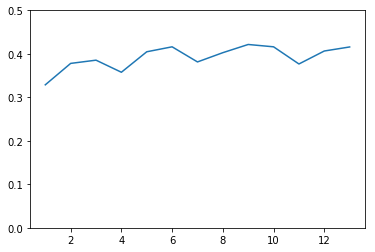

In [0]:
#############
####Main#####
#############

output_file = 'alert.txt'  # The text file to write to (for blinks)#
path = 'D:\\Fold1_part1\\01\\0.mov' # the path to the input video
blink_detector(output_file,path)

In [0]:
cv2.destroyAllWindows()